# Global Terrorism Database (GTD) - Exploratory Data Analysis

This notebook explores the Global Terrorism Database, which records worldwide terrorist incidents from 1970 to 2017.  
The goal is to clean and analyze the dataset to uncover key trends in time, geography, attack types, and impact.


# 1. Introduction


Terrorism has shaped the global landscape for decades, affecting societies, economies, and international relations. To better understand these events, researchers rely on the Global Terrorism Database (GTD), an open-source project maintained by the University of Maryland. Covering incidents from 1970 to 2017, the GTD is the most comprehensive dataset of its kind, with more than 180,000 recorded attacks worldwide.

This notebook aims to uncover stories hidden within the data. How has terrorism changed over time? Which regions have been most affected? What tactics and targets are most common, and what has been the human cost? By answering these questions, we can gain a clearer picture of terrorism’s global impact and how it has evolved across decades.

The analysis will follow four steps:
1. Data cleaning and preparation.  
2. Exploratory analysis of temporal and geographical patterns.  
3. Investigation of attack types, targets, and perpetrators.  
4. Assessment of impact in terms of casualties and injuries.  

By the end, we aim to not just present statistics, but also highlight meaningful insights that help us understand global terrorism trends—and recognize the limitations of the dataset, which ends in 2017.


# 2.Load and intial inspection

Before diving into analysis, we begin by importing the necessary libraries, loading the dataset, and performing a quick inspection.  
This helps us understand the dataset’s size, structure, and quality, and identify potential issues such as missing values or duplicates.


In [6]:
# ========================
# 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

# Set Seaborn theme for plots
sns.set_theme()




### Load Dataset
We load the Global Terrorism Database (GTD) CSV file.  
Since the dataset is large and has mixed data types, we use `low_memory=False` to avoid warnings.


In [8]:
# ========================
# 2. Load Dataset
# ========================
df = pd.read_csv("dataset_GT.csv", encoding="latin1", low_memory=False)

print(f"The dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")


The dataset contains 181,691 rows and 135 columns.


### First Look
We inspect the first few rows, along with column data types and non-null counts,  
to understand the dataset’s overall structure.


In [10]:
# ========================
# 3. Basic Info
# ========================
print("Dataset shape (rows, columns):", df.shape)

# Peek at the first few rows
display(df.head())

# Check data types and non-null counts
df.info()



Dataset shape (rows, columns): (181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


### Missing Values and Duplicates
Next, we check for missing values and duplicate records.



Top 15 columns with most missing values:
gsubname3           181671
weapsubtype4_txt    181621
weapsubtype4        181621
weaptype4           181618
weaptype4_txt       181618
claimmode3          181558
claimmode3_txt      181558
gsubname2           181531
claim3              181373
guncertain3         181371
gname3              181367
divert              181367
attacktype3         181263
attacktype3_txt     181263
ransomnote          181179
dtype: int64

Number of duplicate rows: 0


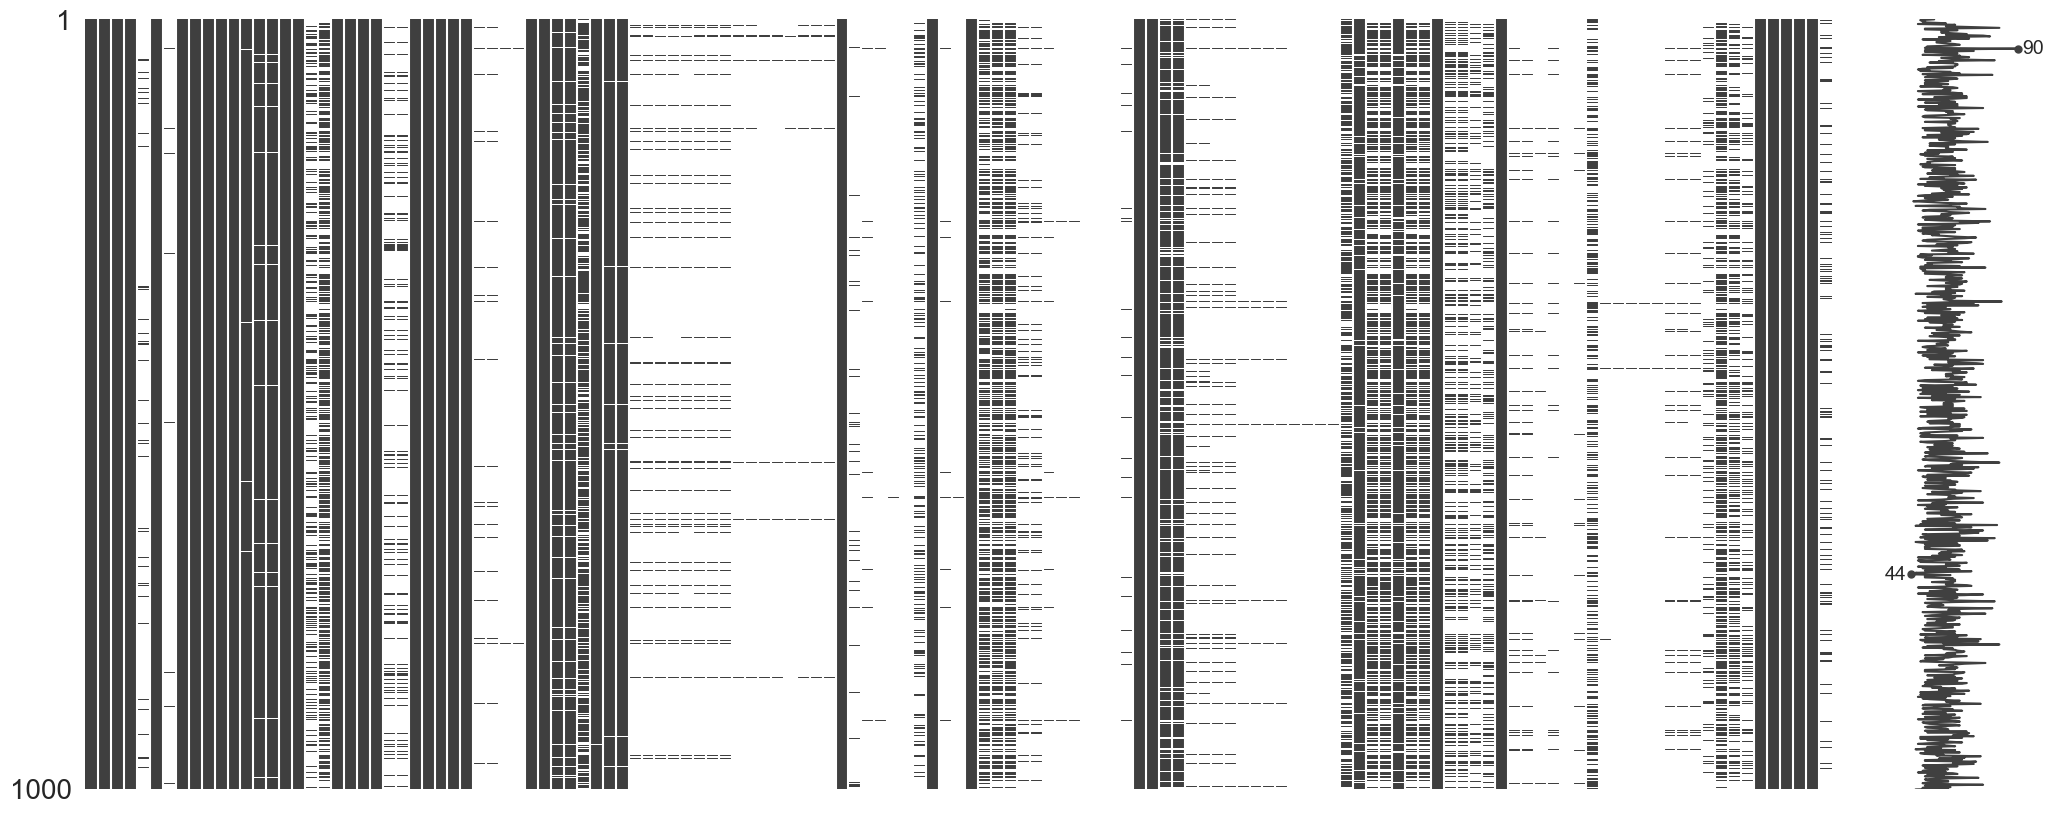

In [12]:
# ========================
# 4. Missing Values
# ========================
import missingno as msno

missing = df.isnull().sum().sort_values(ascending=False)
print("\nTop 15 columns with most missing values:")
print(missing.head(15))

# Quick visualization of missingness (sample of 1000 for readability)
msno.matrix(df.sample(1000))

# ========================
# 5. Duplicate Check
# ========================
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")


In [13]:
# !pip install missingno


### Quick Summary
- The dataset has ~181,000 rows and 135 columns.  
- Several columns (e.g., `gsubname3`, `weapsubtype4`) are almost entirely missing.  
- No duplicate rows were found.  

For clarity in later analysis, we will rename key columns such as `iyear`, `imonth`, `iday`, `country_txt`, and `region_txt`.


# 3.Data cleaning

In [16]:
# ========================
# 3. Data Cleaning
# ========================

# Columns we keep
keep_cols = [
    'iyear', 'imonth', 'iday',
    'country_txt', 'region_txt', 'provstate', 'city',
    'attacktype1_txt', 'targtype1_txt', 'gname',
    'nkill', 'nwound', 'property', 'propextent_txt',
    'weaptype1_txt', 'suicide', 'success', 'multiple',
    'latitude', 'longitude' 
]

df_clean = df[keep_cols].copy()
print("Shape after column reduction:", df_clean.shape)


Shape after column reduction: (181691, 20)


In [17]:
# ---- A) Date construction with precision flags (do NOT overwrite meaning of 0) ----
df_clean['month_unknown'] = (df_clean['imonth'] == 0)
df_clean['day_unknown']   = (df_clean['iday']   == 0)

# temporary safe month/day to build a valid date (use 1 only for construction)
tmp_month = df_clean['imonth'].replace(0, 1)
tmp_day   = df_clean['iday'].replace(0, 1)

df_clean['date'] = pd.to_datetime(
    dict(year=df_clean['iyear'], month=tmp_month, day=tmp_day),
    errors='coerce'
)

# date precision label
def _precision(r):
    if r['imonth'] == 0: return 'year_only'
    if r['iday']   == 0: return 'no_day'
    return 'exact'
df_clean['date_precision'] = df_clean.apply(_precision, axis=1)

In [18]:
# ---- B) Standardize missing/unknowns in categoricals ----
cat_cols = [
    'country_txt','region_txt','provstate','city',
    'attacktype1_txt','targtype1_txt','gname','weaptype1_txt','propextent_txt'
]
# Normalize whitespace/case; keep literal "Unknown" as canonical token
for c in cat_cols:
    df_clean[c] = (df_clean[c]
                   .astype('string')
                   .str.strip()
                   .fillna('Unknown')
                   .replace({'unknown':'Unknown','UNKNOWN':'Unknown'}))

# city title-case except "Unknown"
df_clean['city'] = df_clean['city'].where(df_clean['city'].eq('Unknown'),
                                          df_clean['city'].str.title())

In [19]:
import numpy as np

num_int_cols = ['nkill','nwound','suicide','success','multiple']

for c in num_int_cols:
    s = pd.to_numeric(df_clean[c], errors='coerce')
    bad = s.dropna().replace([np.inf,-np.inf], np.nan).dropna()
    bad_mask = (bad % 1 != 0)
    print(f"{c:10s} non-integer count:", bad_mask.sum())


nkill      non-integer count: 0
nwound     non-integer count: 2
suicide    non-integer count: 0
success    non-integer count: 0
multiple   non-integer count: 0


In [20]:
# Fix nwound safely
df_clean['nwound'] = pd.to_numeric(df_clean['nwound'], errors='coerce')

# Replace ±inf with NaN
import numpy as np
df_clean['nwound'] = df_clean['nwound'].replace([np.inf, -np.inf], np.nan)

# Handle the 2 non-integers
# Option A: round to nearest
df_clean['nwound'] = df_clean['nwound'].round()


# Finally cast
df_clean['nwound'] = df_clean['nwound'].astype('Int64')


In [21]:
# ---- C) Numeric columns with nullable dtypes; preserve unknown vs zero ----
num_int_cols = ['nkill','nwound','suicide','success','multiple']
for c in num_int_cols:
    # keep NA as <NA> (not 0) using nullable Int64
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').astype('Int64')

# known/unknown flags for casualties
df_clean['killed_known']  = df_clean['nkill' ].notna()
df_clean['wounded_known'] = df_clean['nwound'].notna()

# Convenience filled versions for charts (do not overwrite originals)
df_clean['nkill_filled']  = df_clean['nkill' ].fillna(0).astype('Int64')
df_clean['nwound_filled'] = df_clean['nwound'].fillna(0).astype('Int64')



In [22]:
# ---- D) Geo columns numeric ----
for c in ['latitude','longitude','property']:
    if c in df_clean:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')




In [23]:

# ---- E) Cast high-cardinality text to category to save memory & speed up groupbys ----
for c in cat_cols:
    df_clean[c] = df_clean[c].astype('category')
df_clean['date_precision'] = df_clean['date_precision'].astype('category')

In [24]:
# ---- F) Sanity checks / tiny QA report ----
print("\n== QA report ==")
print("Rows, Cols:", df_clean.shape)
print("Exact dates:", (df_clean['date_precision']=='exact').sum())
print("No day only:", (df_clean['date_precision']=='no_day').sum())
print("Year only :", (df_clean['date_precision']=='year_only').sum())
print("Killed known % :", round(100*df_clean['killed_known'].mean(), 2))
print("Wounded known %:", round(100*df_clean['wounded_known'].mean(), 2))
print("Unique countries:", df_clean['country_txt'].nunique())
print("Unique attack types:", df_clean['attacktype1_txt'].nunique())


== QA report ==
Rows, Cols: (181691, 28)
Exact dates: 180800
No day only: 871
Year only : 20
Killed known % : 94.32
Wounded known %: 91.02
Unique countries: 205
Unique attack types: 9


In [25]:
# Final peek
df_clean.info()
display(df_clean.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   iyear            181691 non-null  int64         
 1   imonth           181691 non-null  int64         
 2   iday             181691 non-null  int64         
 3   country_txt      181691 non-null  category      
 4   region_txt       181691 non-null  category      
 5   provstate        181691 non-null  category      
 6   city             181691 non-null  category      
 7   attacktype1_txt  181691 non-null  category      
 8   targtype1_txt    181691 non-null  category      
 9   gname            181691 non-null  category      
 10  nkill            171378 non-null  Int64         
 11  nwound           165380 non-null  Int64         
 12  property         181691 non-null  int64         
 13  propextent_txt   181691 non-null  category      
 14  weaptype1_txt    181

,iyear,imonth,iday,country_txt,region_txt,provstate,city,attacktype1_txt,targtype1_txt,gname,...,latitude,longitude,month_unknown,day_unknown,date,date_precision,killed_known,wounded_known,nkill_filled,nwound_filled
0,1970,7,2,Dominican Republic,Central America & Caribbean,Unknown,Santo Domingo,Assassination,Private Citizens & Property,MANO-D,...,18.456792,-69.951164,False,False,1970-07-02,exact,True,True,1,0
1,1970,0,0,Mexico,North America,Federal,Mexico City,Hostage Taking (Kidnapping),Government (Diplomatic),23rd of September Communist League,...,19.371887,-99.086624,True,True,1970-01-01,year_only,True,True,0,0
2,1970,1,0,Philippines,Southeast Asia,Tarlac,Unknown,Assassination,Journalists & Media,Unknown,...,15.478598,120.599741,False,True,1970-01-01,no_day,True,True,1,0


# 4. EDA

## 4.1 Over time

**Why this matters.** Time trends show how terrorism evolved, where peaks occurred, and whether the average severity of incidents is changing. I analyse:
1) total attacks per year,  
2) total casualties (fatalities & injuries) per year, and  
3) average casualties per attack (severity) per year.

**Notes on data quality.** Some incidents have unknown month/day; yearly counts use `iyear` to avoid date-precision bias. Casualties use zeros for missing values only for aggregation (the original `nkill`/`nwound` remain untouched for integrity).


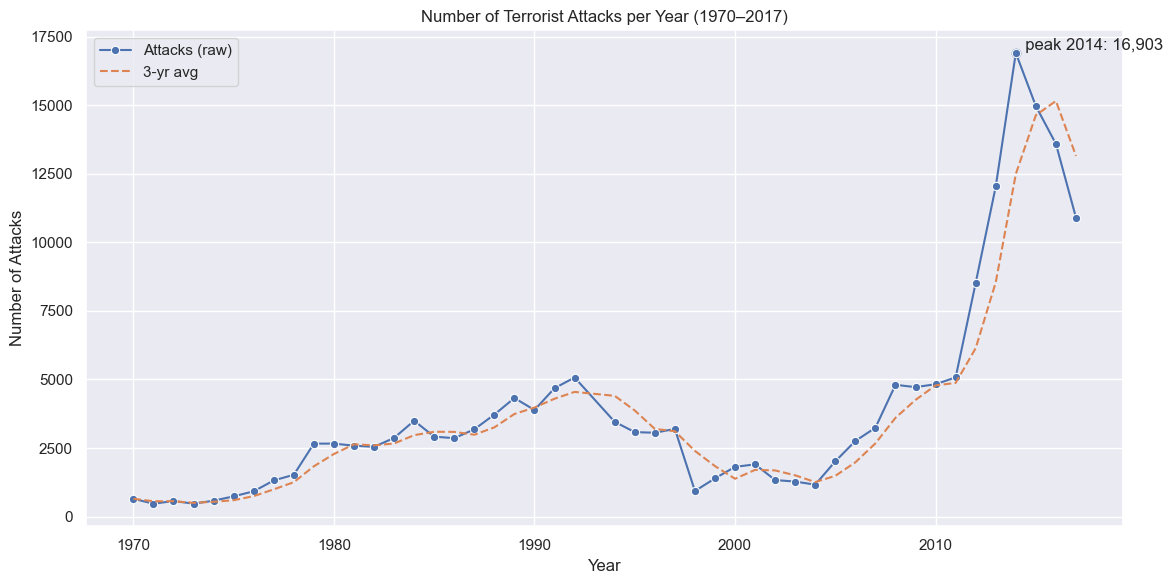

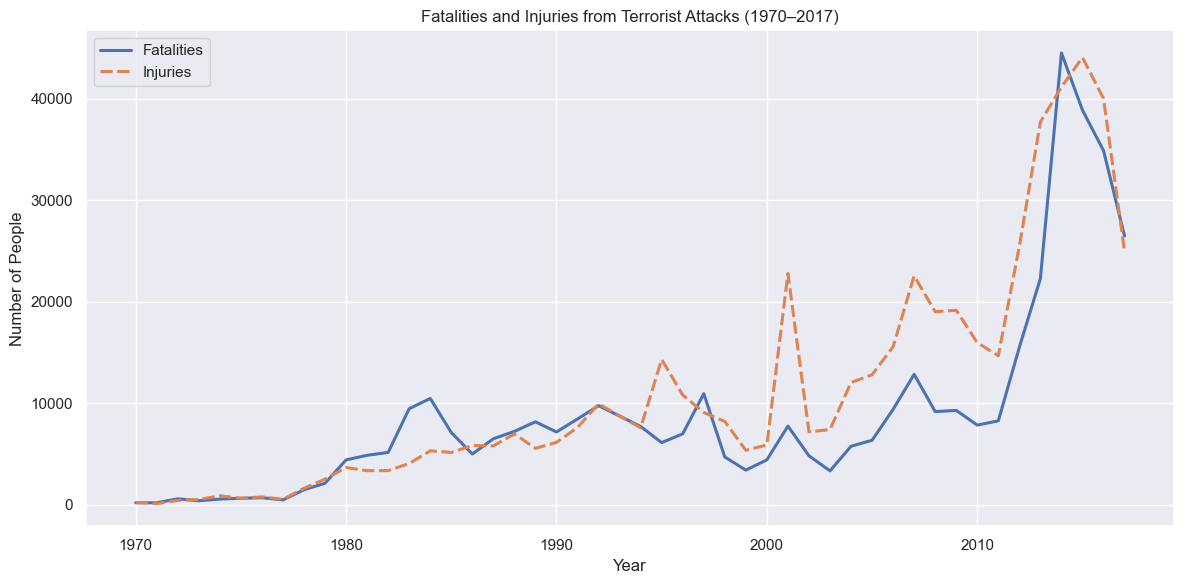

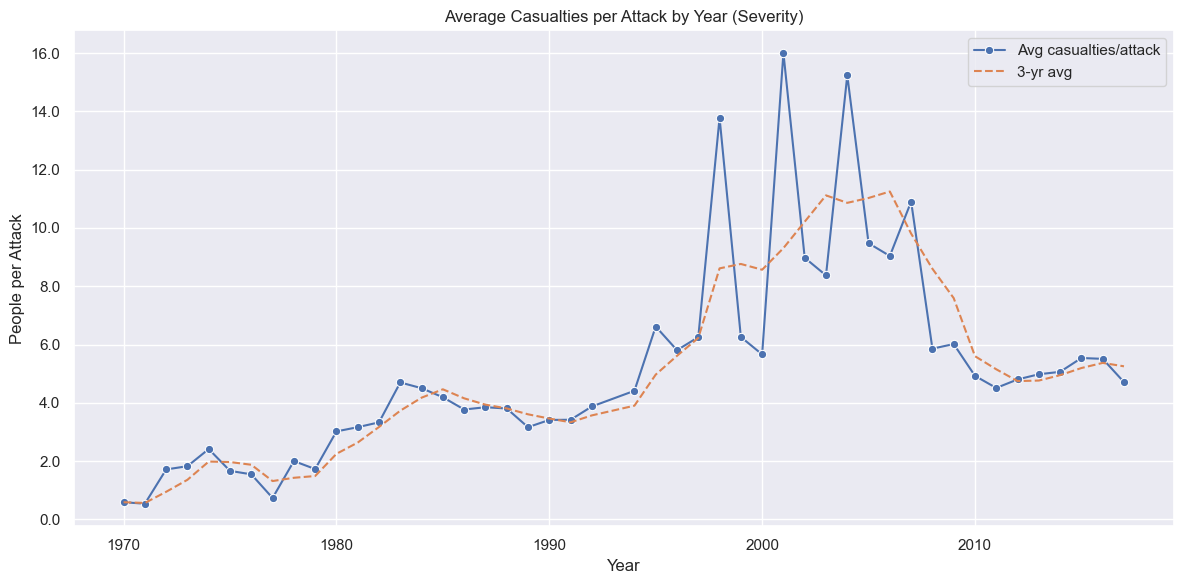

Attacks peak: 2014 (16,903 attacks)
Worst casualty years (by totals): 2014, 2015, 2016
Highest severity years: 2001, 2004, 1998


In [28]:
# ========= Over Time =========
import matplotlib.ticker as mtick
import numpy as np

# ---- Safe year column (prefer iyear; fallback to date.year if present) ----
_year = df_clean['iyear'].copy()
if 'date' in df_clean.columns:
    _year = df_clean['date'].dt.year.fillna(df_clean['iyear'])

_year = _year.astype(int)
tmp = df_clean.copy()
tmp['year'] = _year

# ---- Convenience filled casualties for aggregation (keep originals intact) ----
if 'nkill_filled' not in tmp.columns:
    tmp['nkill_filled']  = pd.to_numeric(tmp['nkill'], errors='coerce').fillna(0).astype(int)
if 'nwound_filled' not in tmp.columns:
    tmp['nwound_filled'] = pd.to_numeric(tmp['nwound'], errors='coerce').fillna(0).astype(int)

# =========================
# 1) Number of attacks / year
# =========================
attacks_per_year = tmp.groupby('year').size().rename('attacks')
# 3-year rolling for smoother visual (doesn't replace the raw curve)
attacks_roll3 = attacks_per_year.rolling(3, min_periods=1).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=attacks_per_year.index, y=attacks_per_year.values, marker="o", label="Attacks (raw)")
sns.lineplot(x=attacks_roll3.index, y=attacks_roll3.values, linestyle="--", label="3-yr avg")

# Annotate peak year
peak_year = int(attacks_per_year.idxmax())
peak_val  = int(attacks_per_year.max())
plt.scatter([peak_year], [peak_val])
plt.text(peak_year, peak_val, f"  peak {peak_year}: {peak_val:,}", va="bottom")

plt.title("Number of Terrorist Attacks per Year (1970–2017)")
plt.xlabel("Year"); plt.ylabel("Number of Attacks")
plt.tight_layout()
plt.show()

# =========================
# 2) Total casualties / year (fatalities & injuries)
# =========================
cas_year = (tmp.groupby('year')[['nkill_filled','nwound_filled']]
              .sum()
              .rename(columns={'nkill_filled':'Fatalities','nwound_filled':'Injuries'}))

plt.figure(figsize=(12,6))
sns.lineplot(data=cas_year[['Fatalities','Injuries']], linewidth=2.2)
plt.title("Fatalities and Injuries from Terrorist Attacks (1970–2017)")
plt.xlabel("Year"); plt.ylabel("Number of People")
plt.legend(title=None)
plt.tight_layout()
plt.show()

# =========================
# 3) Average casualties per attack (severity) / year
# =========================
severity_year = (
    (cas_year['Fatalities'] + cas_year['Injuries']) / attacks_per_year
).rename("Avg casualties per attack")

sev_roll3 = severity_year.rolling(3, min_periods=1).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=severity_year.index, y=severity_year.values, marker="o", label="Avg casualties/attack")
sns.lineplot(x=sev_roll3.index, y=sev_roll3.values, linestyle="--", label="3-yr avg")
plt.title("Average Casualties per Attack by Year (Severity)")
plt.xlabel("Year"); plt.ylabel("People per Attack")
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.legend(title=None)
plt.tight_layout()
plt.show()

# =========================
# 4) One-line takeaway (prints under the charts)
# =========================
print("Attacks peak:", peak_year, f"({peak_val:,} attacks)")
print("Worst casualty years (by totals):", ", ".join(map(str, cas_year.sum(axis=1).nlargest(3).index.tolist())))
print("Highest severity years:", ", ".join(map(str, severity_year.nlargest(3).index.tolist())))


**Observations (Over Time):**
- Terrorist incidents increased steadily from the 1970s, with **notable peaks in the early 1990s** and a sharp surge after **2010**, reaching a record high in **2014 with 16,903 attacks**.
- Fatalities and injuries follow a similar upward trend, with the **worst casualty years** being **2014–2016** (over 40,000 victims annually).
- While the number of incidents declines after 2014, the **average casualties per attack (severity)** peaked earlier in **1998, 2001, and 2004**, reflecting rare but catastrophic events (e.g., 9/11).
- Overall, terrorism became **more frequent after 2010**, but **most deadly on a per-attack basis around the late 1990s–early 2000s**.


## 4.2 By geography

**Why this matters.** Geography reveals where terrorist activity concentrates and how regional dynamics shift over time.  
I present: (1) top countries by total incidents with percentages, (2) attacks by region, (3) regional trends over time (top 5 regions to reduce clutter), and (4) an interactive map.

**Notes.** Counts use `country_txt` and `region_txt`. For time, I use `iyear` (robust to unknown month/day). The map uses clustering/heatmap so we don’t overload the browser with millions of markers.


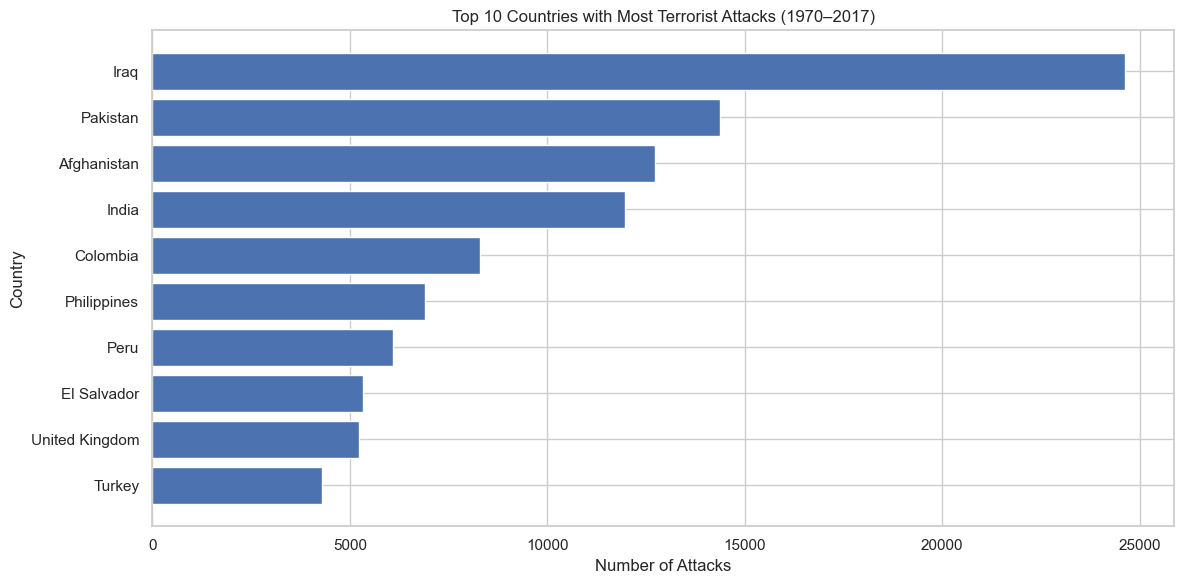

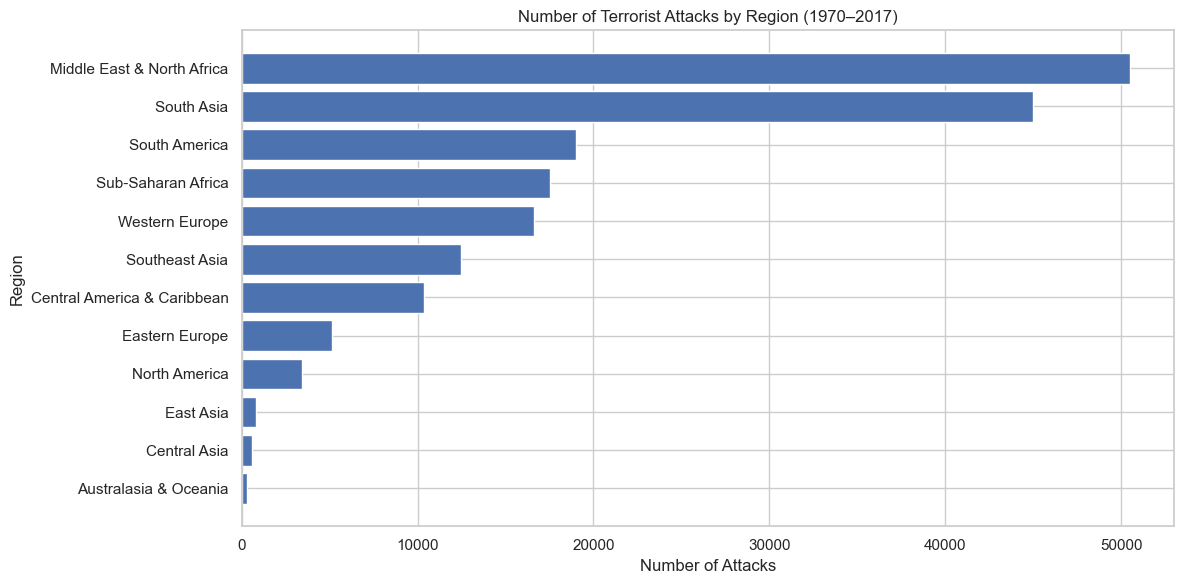

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3557185637.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['iyear','region_txt'])
/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3557185637.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_region.groupby('region_txt')['attacks'].sum()
/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3557185637.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

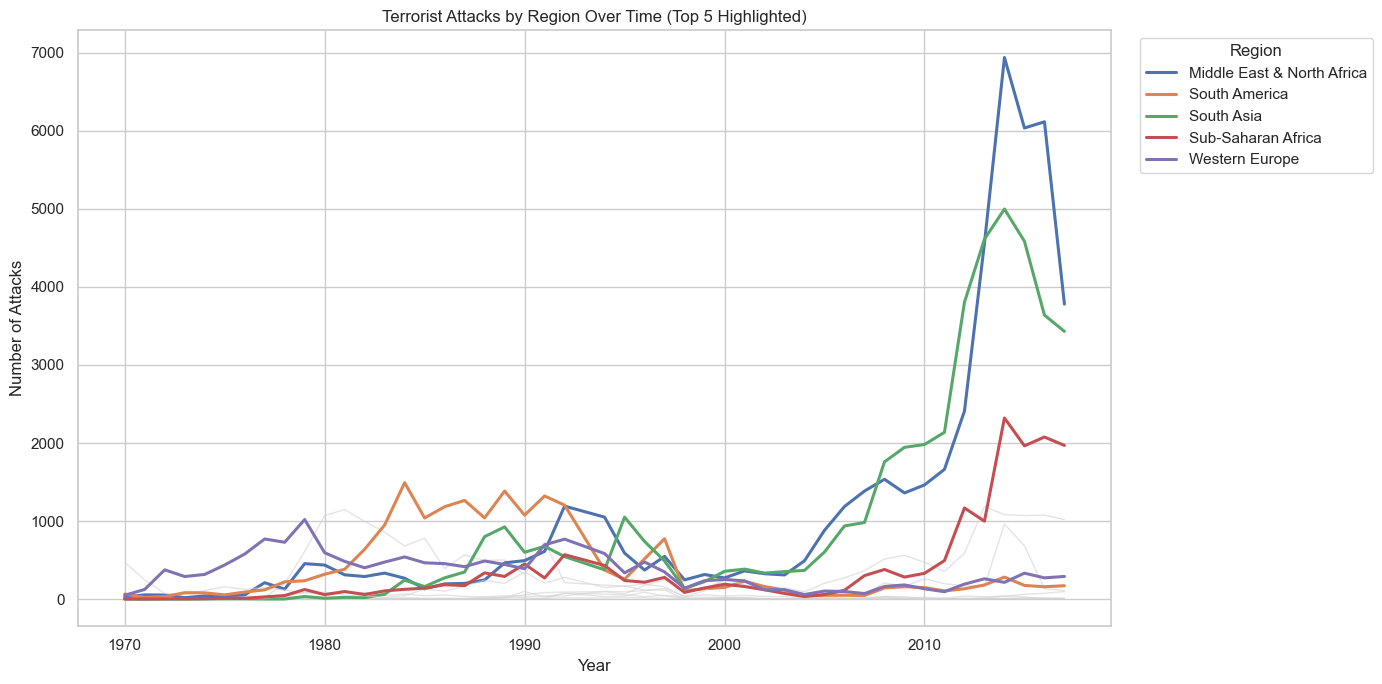

In [31]:
# ========= 4.2 By Geography (clean + robust) =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ---------- A) Top 10 countries by incidents ----------
# cast to str only for counting (doesn't change df_clean)
country_counts = df_clean['country_txt'].astype(str).value_counts()

top10_countries = (
    country_counts
    .nlargest(10)                         # exactly 10
    .rename_axis('country')
    .reset_index(name='attacks')
    .sort_values('attacks', ascending=True)  # for horizontal bar from bottom-up
)

plt.figure(figsize=(12,6))
# Matplotlib is safest for pre-aggregated bars
plt.barh(top10_countries['country'], top10_countries['attacks'])
plt.title("Top 10 Countries with Most Terrorist Attacks (1970–2017)")
plt.xlabel("Number of Attacks"); plt.ylabel("Country")
plt.tight_layout()
plt.show()


# ---------- B) Attacks by region (sorted) ----------
region_counts = df_clean['region_txt'].astype(str).value_counts()

region_df = (
    region_counts
    .rename_axis('region')
    .reset_index(name='attacks')
    .sort_values('attacks', ascending=True)
)

plt.figure(figsize=(12,6))
plt.barh(region_df['region'], region_df['attacks'])
plt.title("Number of Terrorist Attacks by Region (1970–2017)")
plt.xlabel("Number of Attacks"); plt.ylabel("Region")
plt.tight_layout()
plt.show()


# ---------- C) Regional trends over time (top 5 highlighted) ----------
year_region = (
    df_clean
    .groupby(['iyear','region_txt'])
    .size()
    .rename('attacks')
    .reset_index()
)

top5_regions = (
    year_region.groupby('region_txt')['attacks'].sum()
    .sort_values(ascending=False).head(5).index.tolist()
)

plt.figure(figsize=(14,7))
for reg, sub in year_region.groupby('region_txt'):
    sub = sub.sort_values('iyear')
    if reg in top5_regions:
        sns.lineplot(x=sub['iyear'], y=sub['attacks'], label=reg, linewidth=2.2)
    else:
        plt.plot(sub['iyear'], sub['attacks'], color='lightgray', linewidth=1, alpha=0.6)

plt.title("Terrorist Attacks by Region Over Time (Top 5 Highlighted)")
plt.xlabel("Year"); plt.ylabel("Number of Attacks")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# ---------- D) Interactive maps (optional) ----------
# Creates two HTML maps in your working dir: terrorism_cluster_map.html & terrorism_heatmap.html
import folium
from folium.plugins import MarkerCluster, HeatMap
from IPython.display import IFrame

geo_df = df_clean.dropna(subset=['latitude','longitude'])

# (1) Cluster map (sample for performance)
sample_n = min(15000, len(geo_df))
geo_sample = geo_df.sample(sample_n, random_state=42)

m_cluster = folium.Map(location=[20,0], zoom_start=2, tiles="cartodbpositron")
cluster = MarkerCluster().add_to(m_cluster)
for _, r in geo_sample.iterrows():
    folium.CircleMarker(
        location=[r['latitude'], r['longitude']],
        radius=2, color=None, fill=True, fill_opacity=0.5
    ).add_to(cluster)

m_cluster.save("terrorism_cluster_map.html")
display(IFrame("terrorism_cluster_map.html", width=900, height=600))

# (2) Heatmap (weighted by casualties if your filled columns exist; otherwise weight=1)
tmp = geo_df.copy()
if {'nkill_filled','nwound_filled'}.issubset(tmp.columns):
    tmp['weight'] = (tmp['nkill_filled'].fillna(0) + tmp['nwound_filled'].fillna(0)).clip(upper=50) + 1
else:
    tmp['weight'] = 1

heat_sample = tmp.sample(min(50000, len(tmp)), random_state=42)
heat_data = heat_sample[['latitude','longitude','weight']].values.tolist()

m_heat = folium.Map(location=[20,0], zoom_start=2, tiles="cartodbpositron")
HeatMap(heat_data, radius=6, blur=8, max_zoom=4).add_to(m_heat)
m_heat.save("terrorism_heatmap.html")
display(IFrame("terrorism_heatmap.html", width=900, height=600))


**Observations (Geography):**

- Terrorist activity is highly concentrated in **Middle East & North Africa** and **South Asia**, which hold the largest regional totals.

- By country, **Iraq** leads by a wide margin; **Pakistan**, **Afghanistan**, and **India** are also consistently high, followed by **Colombia**, **Peru**, and the **Philippines**.

- Regional trend lines show a **sharp post-2010 surge** in **MENA and South Asia**; **Sub-Saharan Africa** rises through the 2010s, while **Western Europe** and **South Americ**a show **earlier peaks and long-run declines**.

- The maps reveal **dense hotspots** along conflict corridors: **Iraq–Syria**, **Afghanistan–Pakistan**, **Kashmir/northern India**, **Nigeria & the Horn of Africa**, **Colombia–Peru**, and **Mindanao (Philippines)**.

Notes: These are volume counts (not per-capita risk); some locations are approximate and reporting intensity varies by place and time.


## 4.3 By attack type

**Why this matters.** Attack type shows *how* terrorism is carried out. Different tactics have different frequencies and impacts — e.g., bombings are most common, but armed assaults often cause more fatalities per incident.  

I analyse:  
1. Distribution of attack types (counts + % share).  
2. Fatalities & injuries by attack type (impact).  
3. Average casualties per attack type (severity).


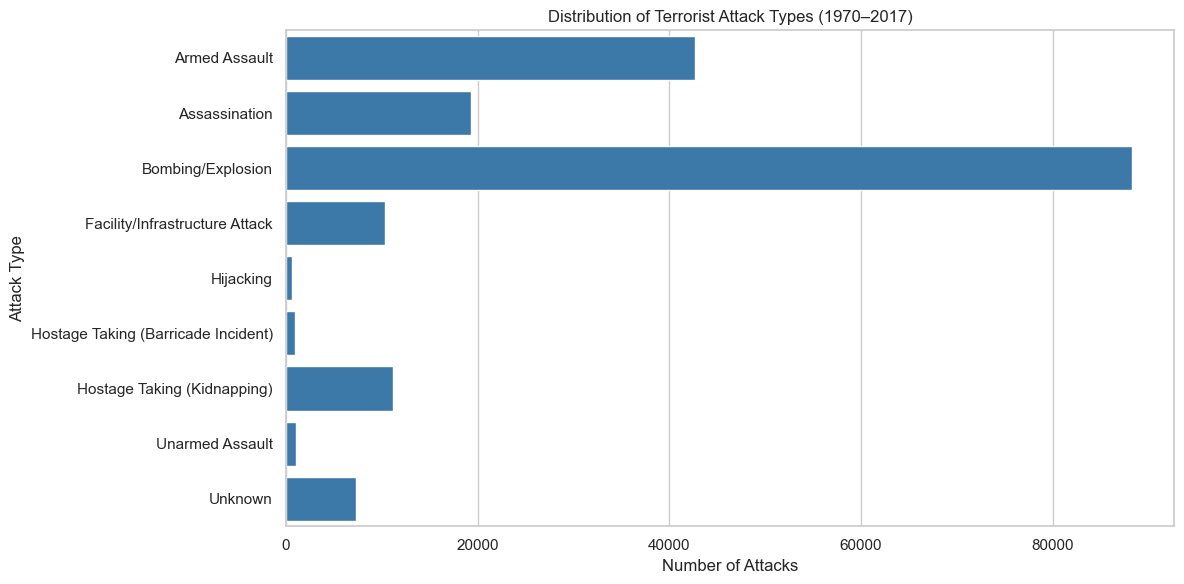

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3291311011.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  impact_df = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]


<Figure size 1200x600 with 0 Axes>

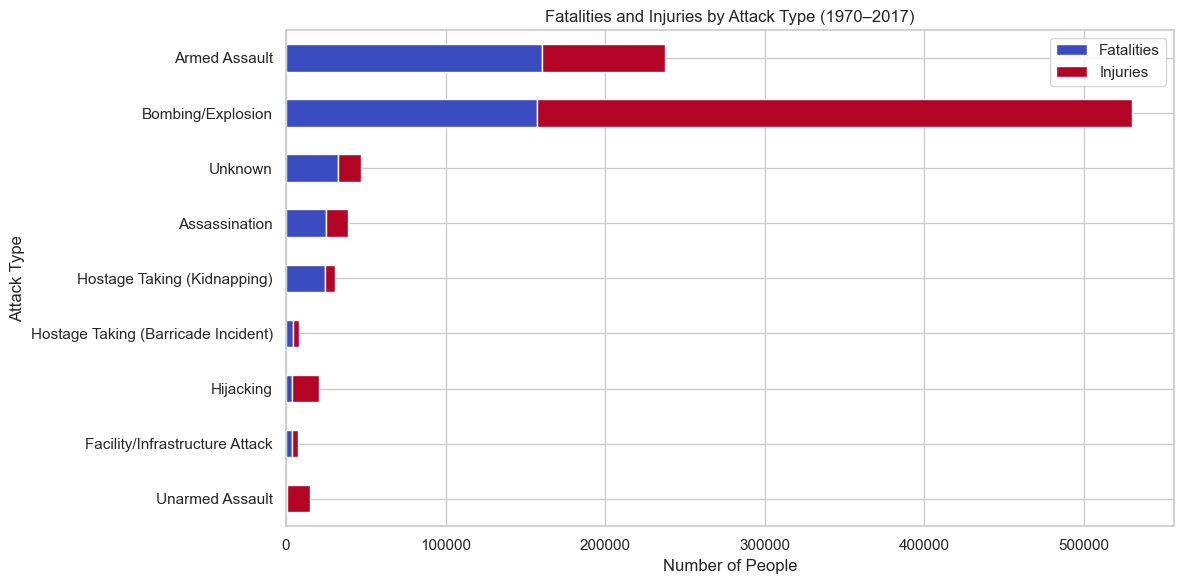

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3291311011.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_df = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]


<Figure size 1200x600 with 0 Axes>

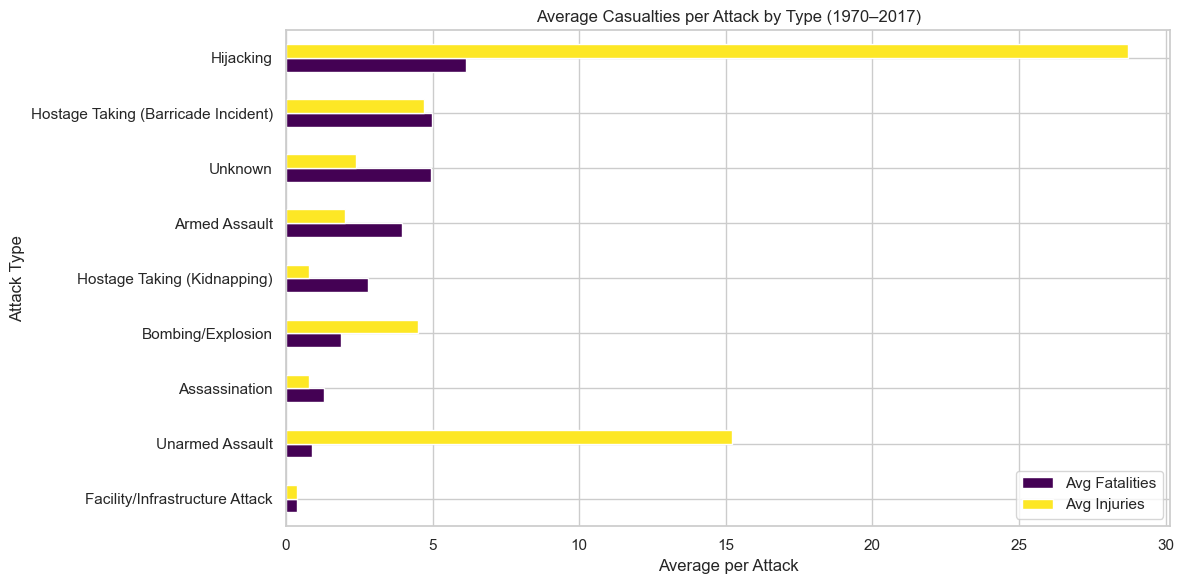

Most common attack type: Bombing/Explosion (88,255 attacks)
Deadliest type (total fatalities): Armed Assault
Most severe type (avg fatalities/attack): Hijacking


In [34]:
# ========= By Attack Type =========

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

# -----------------------------
# 1) Count of attack types — bars only (no labels)
# -----------------------------
EXCLUDE_UNKNOWN = False  # set True if you don't want the "Unknown" category

attack_counts = df_clean['attacktype1_txt'].value_counts(dropna=False)
if EXCLUDE_UNKNOWN:
    attack_counts = attack_counts[attack_counts.index != "Unknown"]

attack_df = (
    attack_counts.rename_axis('AttackType').reset_index(name='Count')
    .sort_values('Count', ascending=False)  # biggest at top
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=attack_df,
    x='Count', y='AttackType',
    color=sns.color_palette("Blues")[4],  # single color → no hue/palette deprecation
    errorbar=None
)
ax.set_title("Distribution of Terrorist Attack Types (1970–2017)")
ax.set_xlabel("Number of Attacks"); ax.set_ylabel("Attack Type")
plt.tight_layout()
plt.show()



# -----------------------------
# 2) Fatalities & injuries by attack type (impact)
# -----------------------------
impact_df = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]
             .sum()
             .rename(columns={'nkill':'Fatalities','nwound':'Injuries'})
             .sort_values('Fatalities', ascending=True))

plt.figure(figsize=(12,6))
impact_df[['Fatalities','Injuries']].plot(kind='barh', stacked=True, figsize=(12,6), colormap="coolwarm")
plt.title("Fatalities and Injuries by Attack Type (1970–2017)")
plt.xlabel("Number of People"); plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()


# -----------------------------
# 3) Average casualties per attack type (severity)
# -----------------------------
severity_df = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]
               .mean()
               .rename(columns={'nkill':'Avg Fatalities','nwound':'Avg Injuries'})
               .sort_values('Avg Fatalities', ascending=True))

plt.figure(figsize=(12,6))
severity_df.plot(kind='barh', figsize=(12,6), colormap="viridis")
plt.title("Average Casualties per Attack by Type (1970–2017)")
plt.xlabel("Average per Attack"); plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()


# -----------------------------
# 4) Quick printed summary
# -----------------------------
print("Most common attack type:", attack_counts.idxmax(), f"({attack_counts.max():,} attacks)")
print("Deadliest type (total fatalities):", impact_df['Fatalities'].idxmax())
print("Most severe type (avg fatalities/attack):", severity_df['Avg Fatalities'].idxmax())


**Observations (By Attack Type):**

- **Bombings/Explosions** dominate the modality mix (roughly half of incidents), followed by **Armed Assault**s and **Hostage-taking/Kidnapping**. Rarer modes such as Hijacking and Barricade incidents form a small share.

- For total harm, **Bombings/Explosions** drive the **most injuries**, while **Armed Assaults** contribute the most fatalities overall. Together they account for the bulk of casualties.

- **Severity ≠ frequency**: **Hijackings** show the **highest casualties** per incident; **Unarmed Assaults and Barricade-type hostage** takings also have **relatively high** per-attack injuries. **Facility/Infrastructure attacks and Assassinations** tend to have lower casualties per event.

- The “Unknown” category still produces substantial totals and non-trivial averages—flag it for careful handling or sensitivity checks in downstream analysis.

- Takeaway: Focusing only on common types (e.g., bombings) reduces many events, but guarding against low-frequency, high-severity modes (e.g., hijacking) is critical for worst-case risk.


## 4.4 By target

**Why this matters.** Target category shows *who or what* is attacked. Governments and security forces face frequent attacks, but the largest human cost often falls on **Private Citizens & Property**. I examine:
1) distribution of targets (counts + % share),
2) fatalities & injuries by target (impact), and
3) average casualties per attack (severity).

**Note.** I retain the original `targtype1_txt` labels and keep unknowns explicit rather than dropping them, to avoid bias.


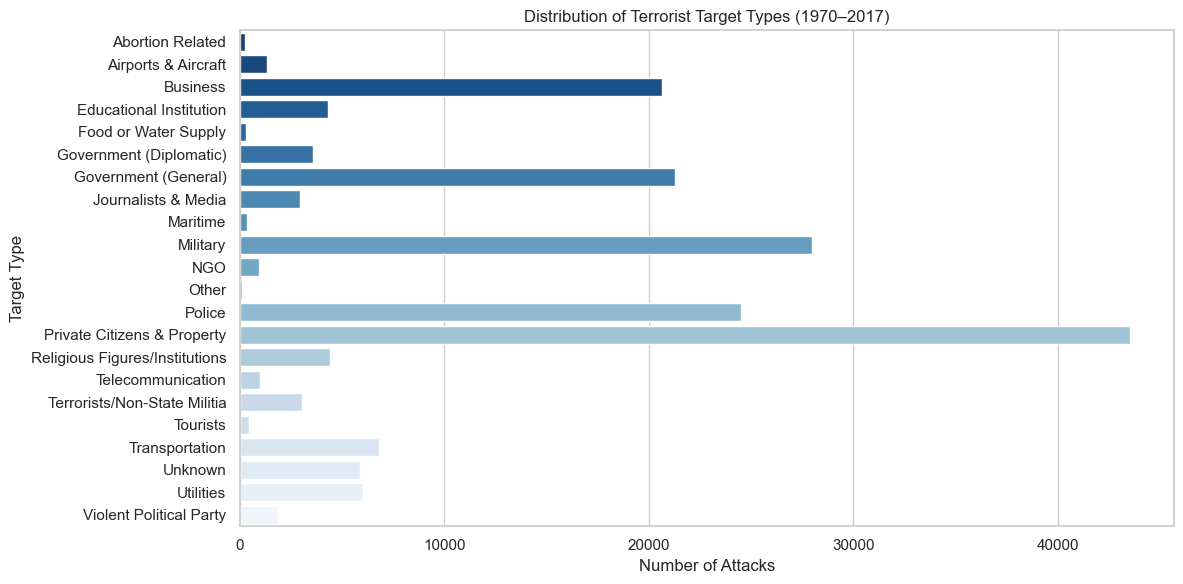

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3719769204.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  impact_by_tgt = (df_clean.groupby('targtype1_txt')[['nkill','nwound']]


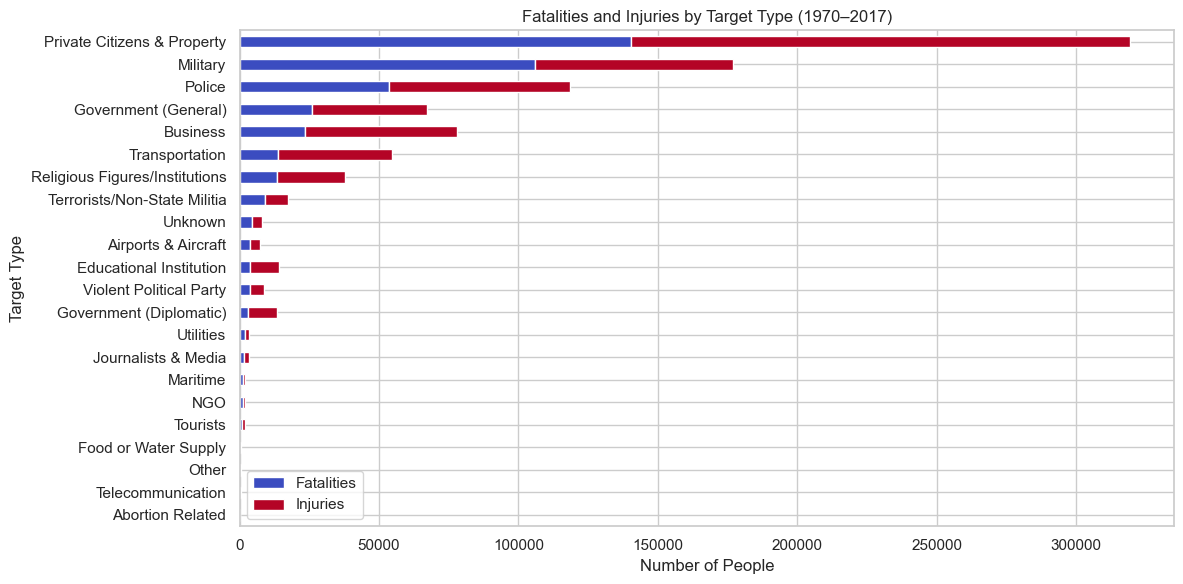

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3719769204.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_by_tgt = (df_clean.groupby('targtype1_txt')[['nkill','nwound']]


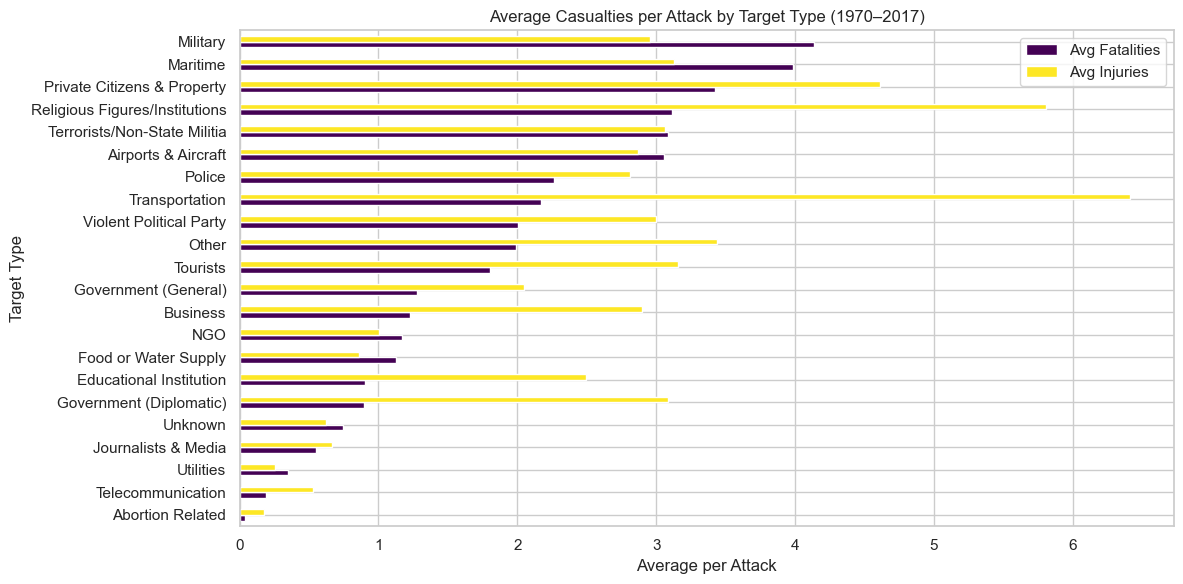

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/3719769204.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['iyear','targtype1_txt']).size()


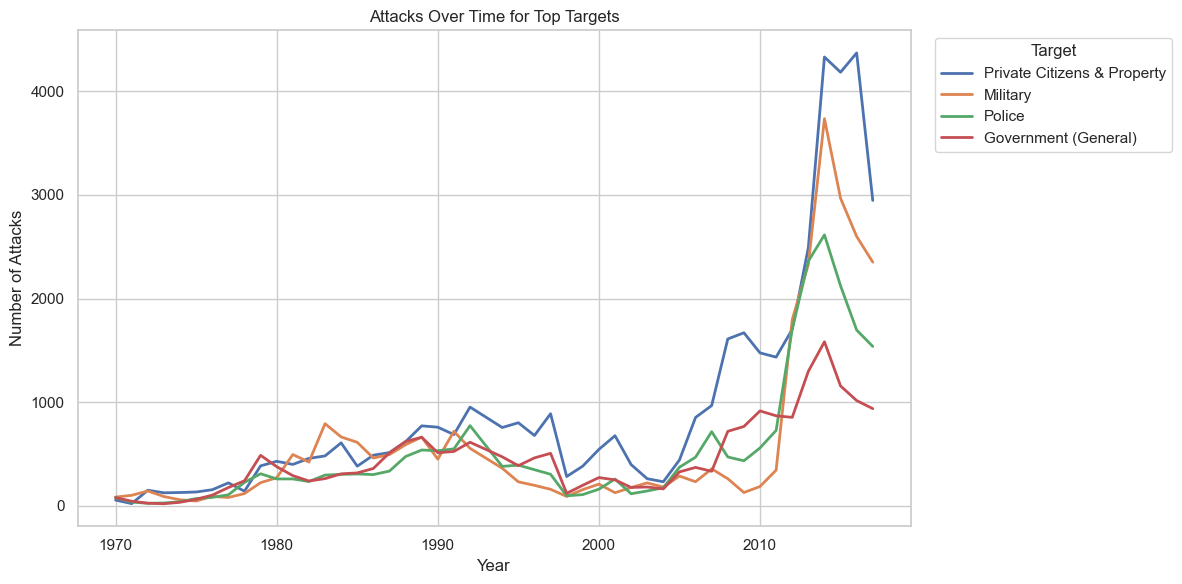

Most frequently targeted: Private Citizens & Property (43,511 attacks)
Highest total fatalities: Private Citizens & Property
Highest severity (avg fatalities/attack): Military


In [37]:
# ========= By Target =========

sns.set_theme(style="whitegrid")

# -----------------------------
# 1) Distribution of targets (counts + %)
# -----------------------------

tgt_counts = df_clean['targtype1_txt'].value_counts()
tgt_share  = (tgt_counts / tgt_counts.sum() * 100).round(1)

tgt_df = (pd.DataFrame({
    'Target': tgt_counts.index,
    'Count':  tgt_counts.values,
    'Share':  tgt_share.values
})
         .sort_values('Count', ascending=True))

plt.figure(figsize=(12,6))
# Use hue='Target' + dodge=False to keep one bar per category and avoid the palette warning
ax = sns.barplot(
    data=tgt_df, x='Count', y='Target',
    hue='Target', palette='Blues_r', dodge=False, legend=False
)
ax.set_title("Distribution of Terrorist Target Types (1970–2017)")
ax.set_xlabel("Number of Attacks")
ax.set_ylabel("Target Type")

# --- important: NO annotations (removed) ---
# If you previously added labels via bar_label somewhere, ensure none remain:
for c in ax.containers:
    try:
        ax.bar_label(c, labels=['']*len(c))  # clears any auto labels if present
    except Exception:
        pass

plt.tight_layout()
plt.show()


# -----------------------------
# 2) Impact: fatalities & injuries by target (stacked)
# -----------------------------
impact_by_tgt = (df_clean.groupby('targtype1_txt')[['nkill','nwound']]
                 .sum()
                 .rename(columns={'nkill':'Fatalities', 'nwound':'Injuries'})
                 .sort_values('Fatalities', ascending=True))

ax = impact_by_tgt[['Fatalities','Injuries']].plot(
    kind='barh', stacked=True, figsize=(12,6), colormap='coolwarm'
)
ax.set_title("Fatalities and Injuries by Target Type (1970–2017)")
ax.set_xlabel("Number of People"); ax.set_ylabel("Target Type")
plt.tight_layout()
plt.show()


# -----------------------------
# 3) Severity: avg casualties per attack by target
# -----------------------------
severity_by_tgt = (df_clean.groupby('targtype1_txt')[['nkill','nwound']]
                   .mean()
                   .rename(columns={'nkill':'Avg Fatalities', 'nwound':'Avg Injuries'})
                   .sort_values('Avg Fatalities', ascending=True))

ax = severity_by_tgt.plot(kind='barh', figsize=(12,6), colormap='viridis')
ax.set_title("Average Casualties per Attack by Target Type (1970–2017)")
ax.set_xlabel("Average per Attack"); ax.set_ylabel("Target Type")
plt.tight_layout()
plt.show()


# -----------------------------
# 4) Optional: trend over time for top 4 targets (decluttered)
# -----------------------------
top4_targets = tgt_counts.head(4).index.tolist()
yr_tgt = (df_clean[df_clean['targtype1_txt'].isin(top4_targets)]
          .groupby(['iyear','targtype1_txt']).size()
          .rename('attacks').reset_index())

plt.figure(figsize=(12,6))
for t in top4_targets:
    sub = yr_tgt[yr_tgt['targtype1_txt'] == t].sort_values('iyear')
    sns.lineplot(x=sub['iyear'], y=sub['attacks'], label=t, linewidth=2.0)
plt.title("Attacks Over Time for Top Targets")
plt.xlabel("Year"); plt.ylabel("Number of Attacks")
plt.legend(title="Target", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


# -----------------------------
# 5) Quick printed summary
# -----------------------------
print("Most frequently targeted:", tgt_counts.idxmax(), f"({tgt_counts.max():,} attacks)")
print("Highest total fatalities:", impact_by_tgt['Fatalities'].idxmax())
print("Highest severity (avg fatalities/attack):", severity_by_tgt['Avg Fatalities'].idxmax())


**Observations (By Target):**

- **Private Citizens & Property** are the most frequently targeted category by a wide margin, and also account for the **largest total casualties (fatalities + injuries)**.

- **State actors—Military, Police, and Government (General)**—collectively make up a large share of incidents and casualties, indicating persistent attacks on security and governance institutions.

- On a **per-attack severity** basis, targets with crowd density or confined settings—**Transportation, Airports & Aircraft, and Tourists**—show higher average casualties than most other categories (mass-casualty potential), even though they occur less often.

- **Religious Figures/Institutions** and **Terrorists/Non-State Militia** sit in the middle: not the most frequent, but with meaningful average harm per incident.

- The “Unknown” target category is non-trivial; results involving it should be interpreted cautiously as they reflect incomplete attribution.

- Trends over time: all top target groups surge after 2010, peaking around 2014, and then decline into 2016–2017—mirroring the overall timeline pattern seen earlier.


## 4.5 By group

**Why this matters.** Group analysis shows which organizations are most active, most lethal, and how their activity changes over time. Because many incidents have **Unknown** perpetrators, I (a) report that share explicitly, then (b) focus comparisons on named groups only.

I present:
1) top groups by number of attacks (with % share),
2) total casualties (fatalities+injuries) by group,
3) activity over time for top groups.


Share of incidents with Unknown group: 45.6%


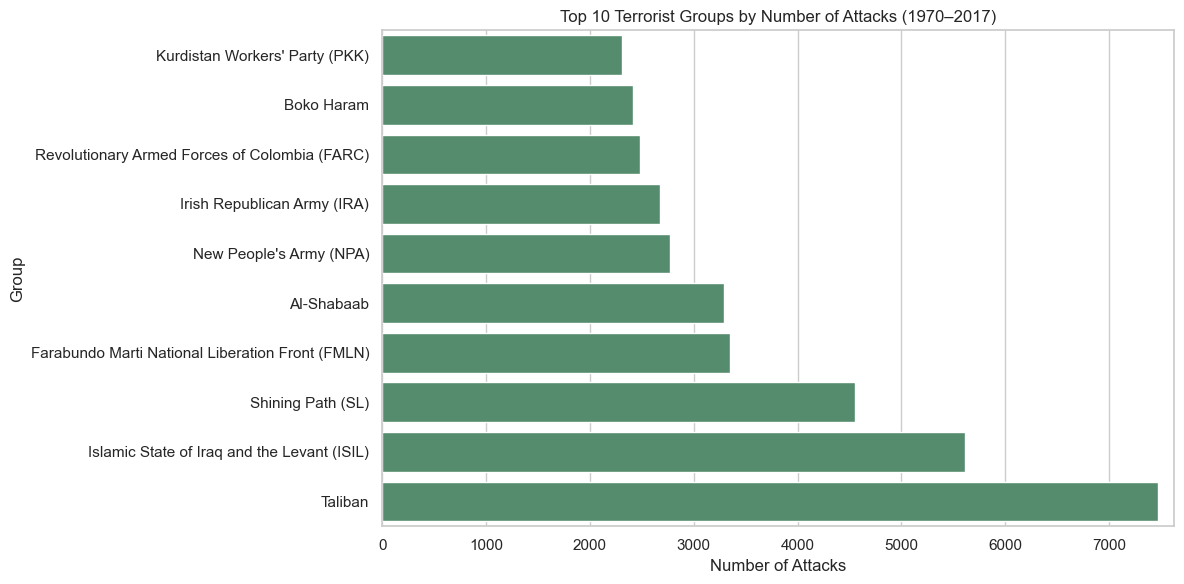

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/2041323191.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cas_by_group = (gdf.groupby('gname')[['nkill','nwound']]


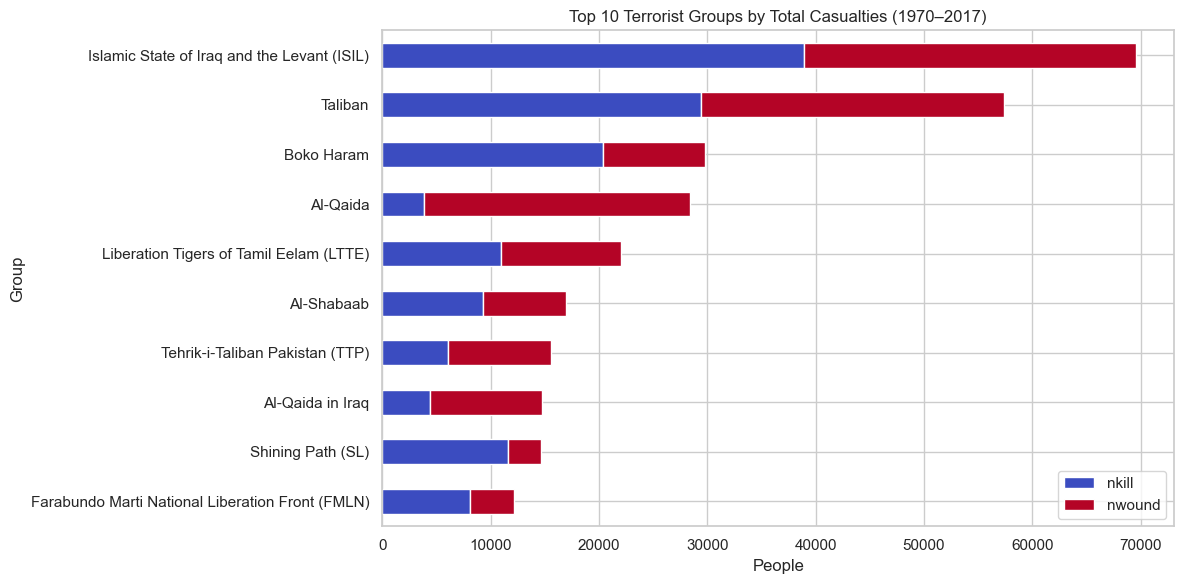

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/2041323191.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['iyear','gname']).size()


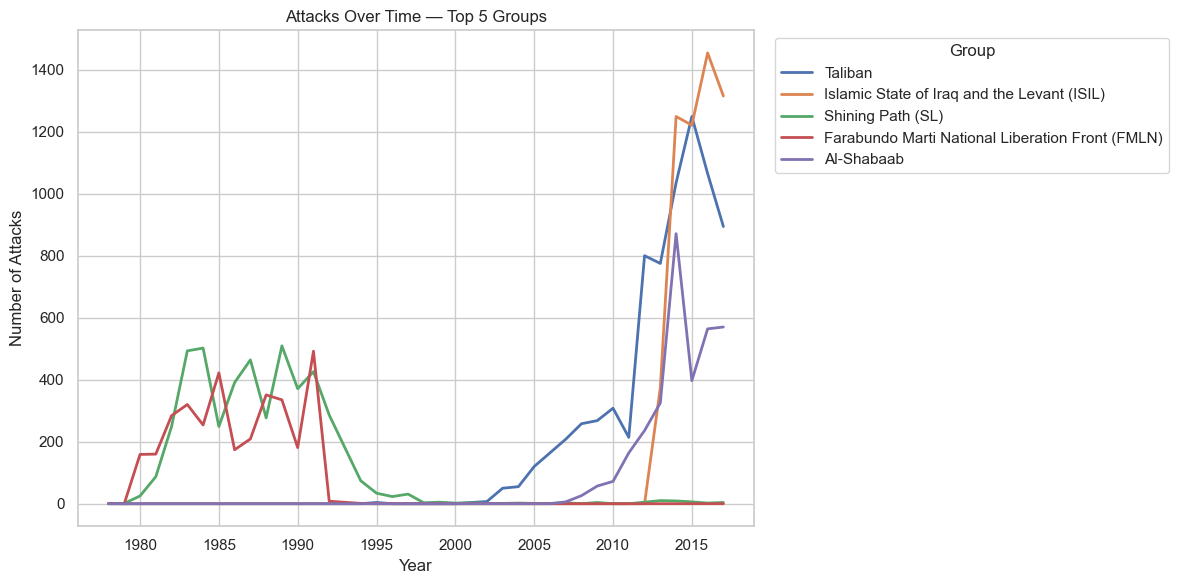

Most active group: Taliban (7,478 attacks)
Highest total casualties: Islamic State of Iraq and the Levant (ISIL)


In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# ---------- A) Unknown share ----------
unknown_share = (df_clean['gname'].eq('Unknown')).mean()*100
print(f"Share of incidents with Unknown group: {unknown_share:.1f}%")

# Work table excluding Unknown for rankings
gdf = df_clean[df_clean['gname'] != 'Unknown'].copy()

# ---------- B) Top groups by number of attacks (counts + %) ----------
attacks_by_group = gdf['gname'].value_counts()

top10_df = (
    attacks_by_group.head(10)
    .rename_axis('Group')
    .reset_index(name='Attacks')
    .sort_values('Attacks', ascending=True)
)

# Make sure y is plain strings (not a categorical with all categories)
top10_df['Group'] = top10_df['Group'].astype(str)
order = top10_df['Group'].tolist()

# Clean plotting state and draw only the 10 rows in 'order'
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=top10_df, x='Attacks', y='Group', order=order, color='#4C956C', ax=ax)

ax.set_title("Top 10 Terrorist Groups by Number of Attacks (1970–2017)")
ax.set_xlabel("Number of Attacks"); ax.set_ylabel("Group")
ax.margins(x=0.02)
plt.tight_layout(); plt.show()


# ---------- C) Top groups by total casualties (Fatalities+Injuries) ----------
cas_by_group = (gdf.groupby('gname')[['nkill','nwound']]
                  .sum()
                  .assign(Total=lambda d: d['nkill']+d['nwound'])
                  .sort_values('Total', ascending=False)
               )
top10_cas = cas_by_group.head(10).iloc[::-1]  # reverse for horizontal bar

ax = top10_cas[['nkill','nwound']].plot(
    kind='barh', stacked=True, figsize=(12,6), colormap='coolwarm'
)
ax.set_title("Top 10 Terrorist Groups by Total Casualties (1970–2017)")
ax.set_xlabel("People"); ax.set_ylabel("Group")
plt.tight_layout(); plt.show()


# ---------- D) Activity over time for top groups ----------
top5 = attacks_by_group.head(5).index.tolist()
yr_grp = (gdf[gdf['gname'].isin(top5)]
          .groupby(['iyear','gname']).size()
          .rename('attacks').reset_index())

plt.figure(figsize=(12,6))
for g in top5:
    sub = yr_grp[yr_grp['gname'] == g].sort_values('iyear')
    sns.lineplot(x=sub['iyear'], y=sub['attacks'], label=g, linewidth=2.0)
plt.title("Attacks Over Time — Top 5 Groups")
plt.xlabel("Year"); plt.ylabel("Number of Attacks")
plt.legend(title="Group", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# ---------- F) Quick printed summary ----------
print("Most active group:", attacks_by_group.idxmax(), f"({attacks_by_group.max():,} attacks)")
print("Highest total casualties:", cas_by_group.index[0])


**Observations (By Group):**

- Attribution coverage: A large share of incidents are unattributed (~45.6% “Unknown”), so **rankings reflect roughly the other half of the data**.

- **Most active by number of attacks** (descending): Taliban (clear #1), ISIL, Shining Path (SL), FMLN, Al-Shabaab, NPA, IRA, FARC, Boko Haram, PKK.

- **Highest total casualties** (fatalities + injuries): ISIL leads, followed by Taliban and Boko Haram; next are Al-Qaida, LTTE, Al-Shabaab, TTP, Al-Qaida in Iraq, Shining Path, FMLN.

- Temporal waves:

    - 1980s–early 1990s: activity centered on SL/FMLN/IRA.

    - Post-2010: sharp rise driven by Taliban/ISIL/Al-Shabaab, aligning with the global peak around 2014–2016.

    - Earlier insurgent groups taper off after the early 1990s; newer jihadist groups dominate the later surge.

## 4.6 By impact

**Why this matters.** Impact measures the human and material cost of terrorism. While most attacks cause few casualties, rare catastrophic events dominate the headlines and global perception. By studying distributions, trends, and outliers, we see both everyday realities and exceptional extremes.

I analyse:
1) distribution of fatalities per attack (linear + log scale),
2) fatalities and injuries over time,
3) the top 10 deadliest individual incidents.


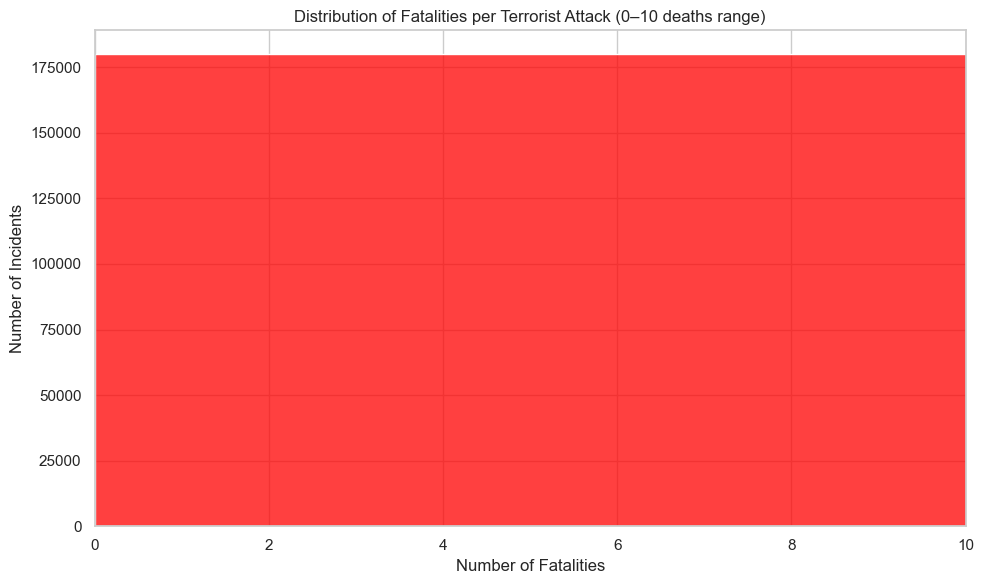

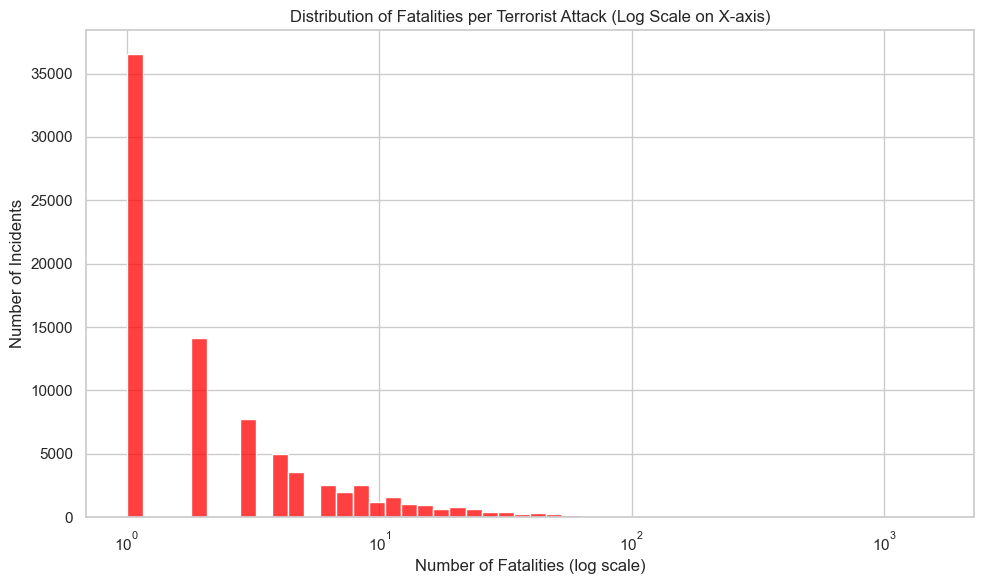

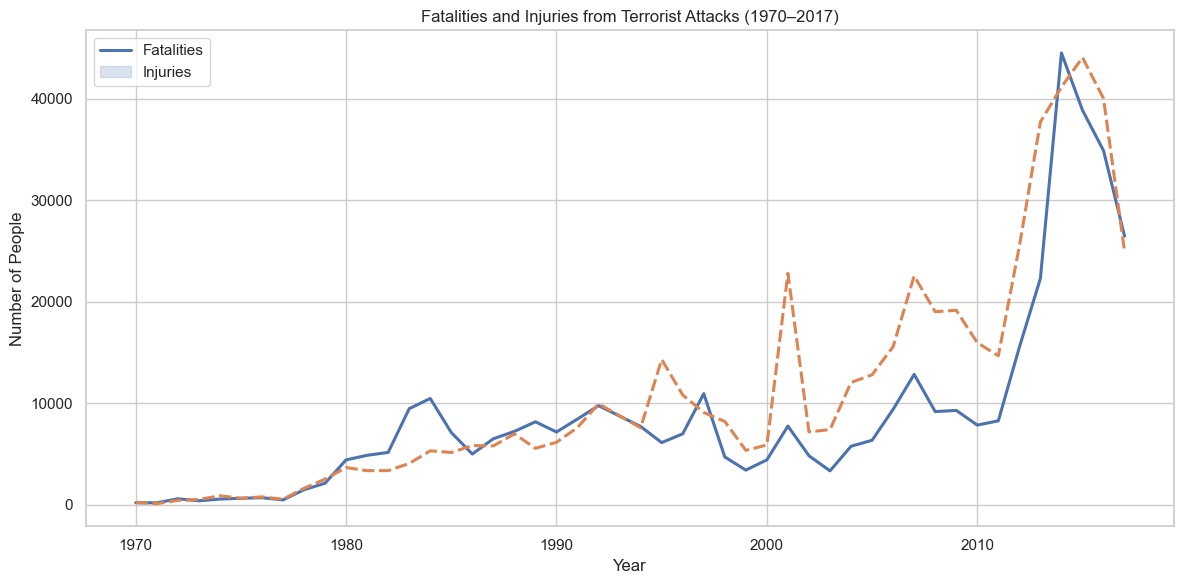

,iyear,country_txt,city,attacktype1_txt,gname,nkill
0,2014,Iraq,Tikrit,Hostage Taking (Kidnapping),Islamic State of Iraq and the Levant (ISIL),1570
1,2001,United States,New York City,Hijacking,Al-Qaida,1384
2,2001,United States,New York City,Hijacking,Al-Qaida,1383
3,1994,Rwanda,Gikoro,Armed Assault,Hutu extremists,1180
4,2014,Iraq,Sinjar,Hostage Taking (Kidnapping),Islamic State of Iraq and the Levant (ISIL),953
5,2014,Iraq,Badush,Armed Assault,Islamic State of Iraq and the Levant (ISIL),670
6,2017,Somalia,Mogadishu,Bombing/Explosion,Al-Shabaab,588
7,2004,Nepal,Dhading District,Armed Assault,Communist Party of Nepal- Maoist (CPN-M),518
8,2014,Syria,Unknown,Hostage Taking (Kidnapping),Islamic State of Iraq and the Levant (ISIL),517
9,2016,Syria,Palmyra,Hostage Taking (Kidnapping),Islamic State of Iraq and the Levant (ISIL),433


Deadliest incident year: 2014
Deadliest incident fatalities: 1570
Group responsible: Islamic State of Iraq and the Levant (ISIL)


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# -----------------------------
# 1) Distribution of fatalities per attack
# -----------------------------
plt.figure(figsize=(10,6))
sns.histplot(df_clean['nkill'].fillna(0), bins=50, color="red")
plt.title("Distribution of Fatalities per Terrorist Attack (0–10 deaths range)")
plt.xlabel("Number of Fatalities"); plt.ylabel("Number of Incidents")
plt.xlim(0, 10)   # zoom in on small values
plt.tight_layout(); plt.show()

# Log-scale version for catastrophic events
plt.figure(figsize=(10,6))
sns.histplot(df_clean.loc[df_clean['nkill']>0,'nkill'], bins=50, color="red", log_scale=(True,False))
plt.title("Distribution of Fatalities per Terrorist Attack (Log Scale on X-axis)")
plt.xlabel("Number of Fatalities (log scale)"); plt.ylabel("Number of Incidents")
plt.tight_layout(); plt.show()


# -----------------------------
# 2) Fatalities and injuries over time
# -----------------------------
impact_over_time = df_clean.groupby('iyear')[['nkill','nwound']].sum()

plt.figure(figsize=(12,6))
sns.lineplot(data=impact_over_time[['nkill','nwound']], linewidth=2.2)
plt.title("Fatalities and Injuries from Terrorist Attacks (1970–2017)")
plt.xlabel("Year"); plt.ylabel("Number of People")
plt.legend(["Fatalities","Injuries"])
plt.tight_layout(); plt.show()


# -----------------------------
# 3) Top 10 deadliest individual incidents
# -----------------------------
deadliest = (
    df_clean[['iyear','country_txt','city','attacktype1_txt','gname','nkill']]
    .sort_values(by='nkill', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

display(deadliest.style.background_gradient(cmap="Reds", subset=['nkill']))

# Annotated summary
print("Deadliest incident year:", int(deadliest.loc[0,'iyear']))
print("Deadliest incident fatalities:", int(deadliest.loc[0,'nkill']))
print("Group responsible:", deadliest.loc[0,'gname'])


**Observations (Impact):**

- Fatalities per attack are highly skewed—most incidents cause 0–1 deaths, with a long tail of rare mass-casualty events.

- Injuries usually exceed fatalities each year, and both series move together.

- Sharp peaks occur in 2001 and 2014–2016, when totals hit their highs.

- Annual spikes are driven by a few catastrophic attacks (e.g., 9/11; ISIL events in 2014–2016), not by broadly higher lethality per incident.

## 4.7 visual telling

**Executive summary:** Terrorist incidents rose from the 1970s and peaked in 2014 (16,903 attacks) before declining. The burden concentrates in MENA and South Asia; Iraq alone accounts for ~13–14% of all incidents. Bombings/Explosions are the most common method, while Private citizens & property are the most frequently targeted. Casualty impact is heavy-tailed—most attacks cause few deaths, but rare events drive the totals. Among named actors, Taliban is the most active; ISIL contributes the most casualties over the period. The post-2014 drop is visible across regions, especially in MENA.

In [122]:
sns.set_theme(style="whitegrid", rc={
    "axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

COLOR_MAIN   = "#2B6CB0"   # blue
COLOR_FADE   = "#BFD7ED"
COLOR_ACCENT = "#D69E2E"   # gold
COLOR_RED    = "#C53030"   # for fatalities
COLOR_ORANGE = "#DD6B20"   # for injuries


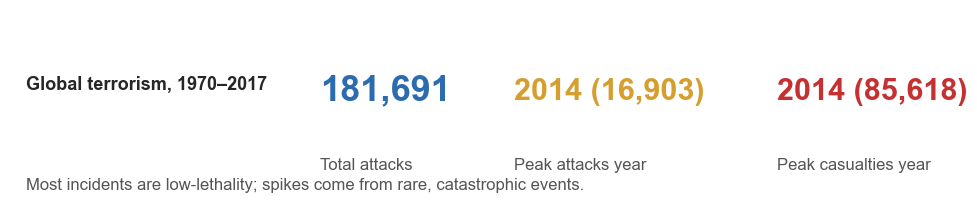

In [134]:

total_attacks = len(df_clean)
year_counts   = df_clean.groupby('iyear').size()
peak_year, peak_attacks = year_counts.idxmax(), year_counts.max()

casualties_by_year = df_clean.groupby('iyear')[['nkill','nwound']].sum().sum(axis=1)
peak_cas_year, peak_casualties = casualties_by_year.idxmax(), casualties_by_year.max()

fig, ax = plt.subplots(figsize=(10,2.6))
ax.axis('off')
ax.text(0.02, 0.6, "Global terrorism, 1970–2017", fontsize=13, weight=600)
ax.text(0.02, 0.1, "Most incidents are low-lethality; spikes come from rare, catastrophic events.", color="#555")

ax.text(0.40, 0.55, f"{total_attacks:,}", fontsize=26, color=COLOR_MAIN, weight=700)
ax.text(0.40, 0.2,  "Total attacks", color="#555")

ax.text(0.65, 0.55, f"{peak_year} ({peak_attacks:,})", fontsize=22, color=COLOR_ACCENT, weight=700)
ax.text(0.65, 0.2,  "Peak attacks year", color="#555")

ax.text(0.99, 0.55, f"{peak_cas_year} ({int(peak_casualties):,})", fontsize=22, color=COLOR_RED, weight=700)
ax.text(0.99, 0.2,  "Peak casualties year", color="#555")
plt.show()


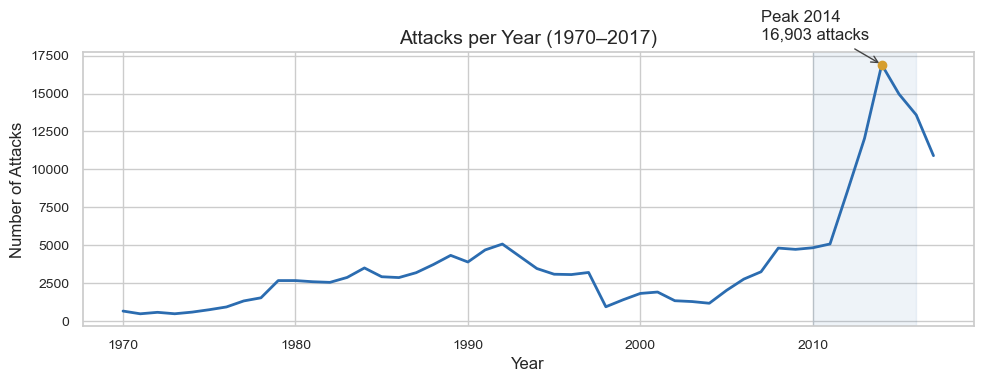

In [136]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(year_counts.index, year_counts.values, color=COLOR_MAIN, lw=2)

# Shade 2010–2016
ax.axvspan(2010, 2016, color=COLOR_MAIN, alpha=0.08, label="Surge period")

# Peak annotation
ax.scatter([peak_year],[peak_attacks], color=COLOR_ACCENT, zorder=5)
ax.annotate(f"Peak {peak_year}\n{peak_attacks:,} attacks",
            xy=(peak_year, peak_attacks), xytext=(peak_year-7, peak_attacks*1.1),
            arrowprops=dict(arrowstyle="->", color="#444"), bbox=dict(boxstyle="round,pad=0.3", fc="white"))
ax.set_title("Attacks per Year (1970–2017)")
ax.set_xlabel("Year"); ax.set_ylabel("Number of Attacks")
plt.tight_layout(); plt.show()


**Incidents surged after 2010, peaking in 2014.**

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/361891141.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yr_reg.groupby('region_txt')['attacks'].sum()


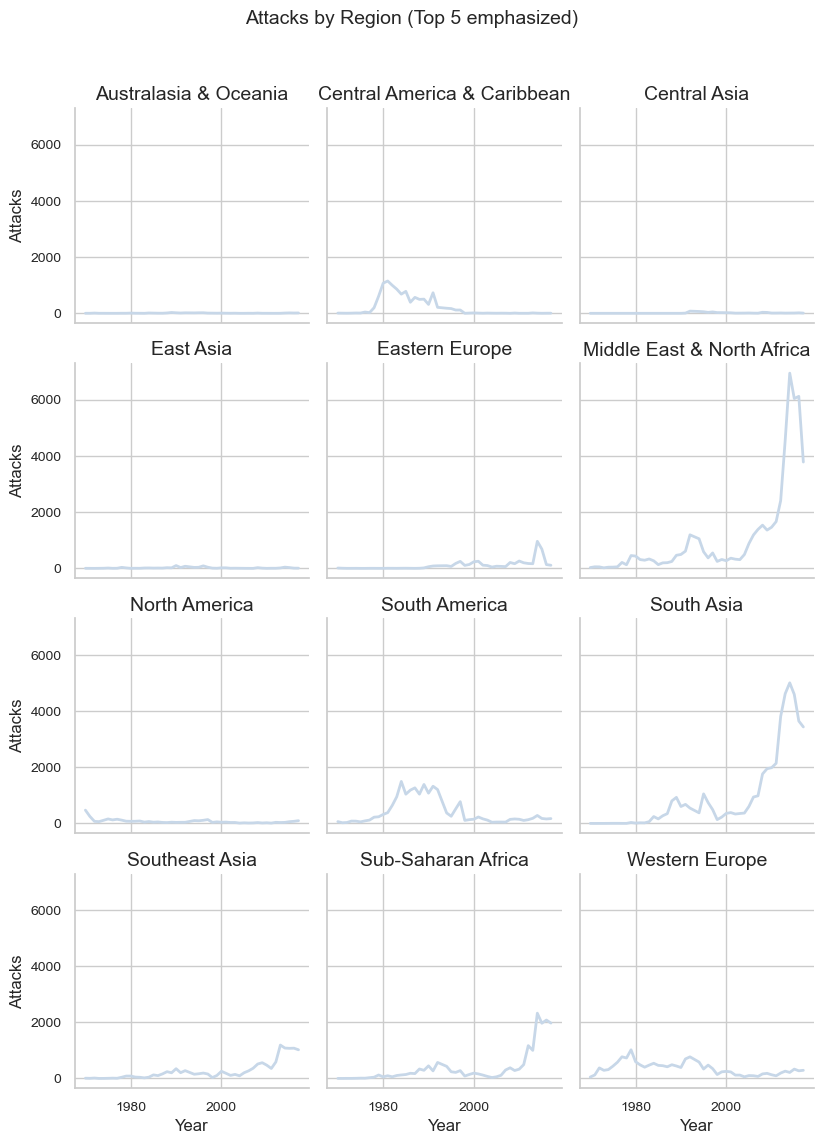

In [140]:
# Year x Region counts
yr_reg = (
    df_clean.groupby(['iyear', 'region_txt'], observed=False)
            .size().rename('attacks').reset_index()
)

top5 = (
    yr_reg.groupby('region_txt')['attacks'].sum()
          .sort_values(ascending=False).head(5).index.tolist()
)

COLOR_MAIN = "#2f6c8e"
COLOR_FADE = "#c7d7e8"

# Faceted small multiples
g = sns.FacetGrid(yr_reg, col="region_txt", col_wrap=3, height=2.8, sharey=True)

def line_per_facet(data, color, **kwargs):
    region = kwargs.get('region_txt')
    clr = COLOR_MAIN if region in top5 else COLOR_FADE
    ax = plt.gca()
    # ensure chronological order within each facet
    d = data.sort_values('iyear')
    ax.plot(d['iyear'], d['attacks'], lw=2, color=clr)

g.map_dataframe(line_per_facet)

for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Attacks")

g.fig.suptitle("Attacks by Region", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


**The burden concentrates in MENA and South Asia; other regions stay comparatively low**

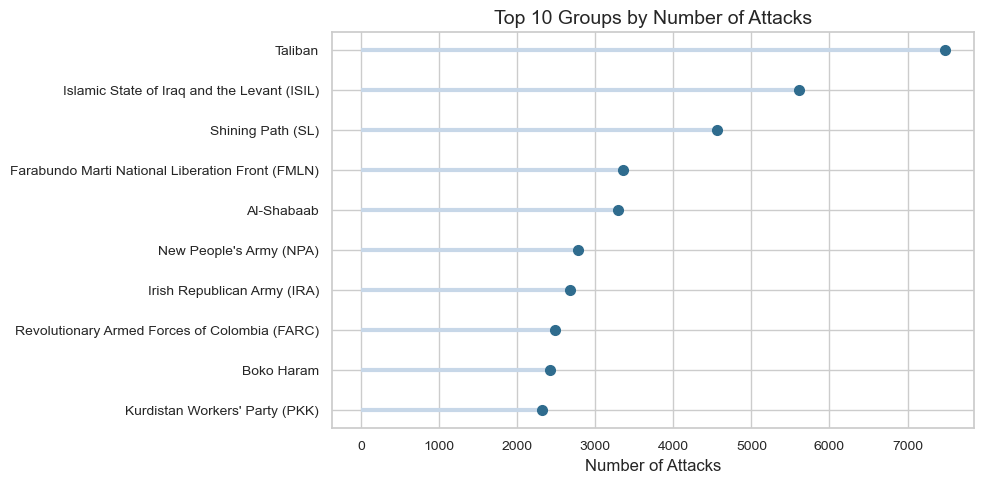

In [142]:
gdf = df_clean[df_clean['gname']!="Unknown"]
top = (gdf['gname'].value_counts().head(10)
       .rename_axis('Group').reset_index(name='Attacks')
       .sort_values('Attacks'))

fig, ax = plt.subplots(figsize=(10,5))
ax.hlines(y=top['Group'], xmin=0, xmax=top['Attacks'], color=COLOR_FADE, lw=3)
ax.plot(top['Attacks'], top['Group'], 'o', color=COLOR_MAIN, ms=7)
ax.set_title("Top 10 Groups by Number of Attacks")
ax.set_xlabel("Number of Attacks"); ax.set_ylabel("")
plt.tight_layout(); plt.show()


**A few groups account for a large share of activity**

/var/folders/m9/p4hgm4s12ss7ncmyttqf3_380000gn/T/ipykernel_1437/908221168.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  impact = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]


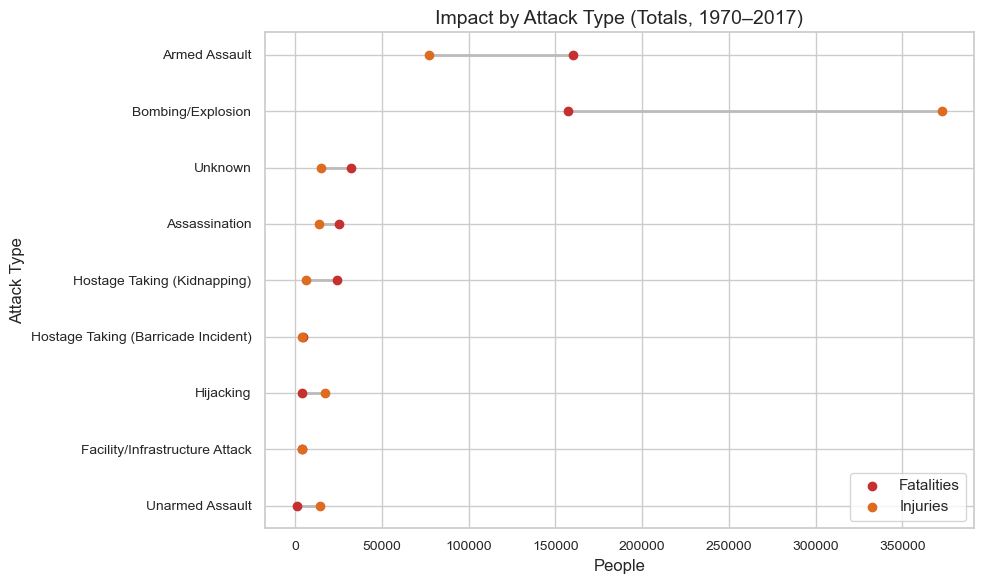

In [144]:
impact = (df_clean.groupby('attacktype1_txt')[['nkill','nwound']]
          .sum().rename(columns={"nkill":"Fatalities","nwound":"Injuries"})
          .sort_values('Fatalities'))

fig, ax = plt.subplots(figsize=(10,6))
y = impact.index
x1, x2 = impact['Fatalities'].values, impact['Injuries'].values
for yi, a, b in zip(y, x1, x2):
    ax.plot([a,b], [yi,yi], color="#bbb", lw=2, zorder=1)
ax.scatter(x1, y, color=COLOR_RED, label="Fatalities", zorder=2)
ax.scatter(x2, y, color=COLOR_ORANGE, label="Injuries", zorder=2)
ax.set_title("Impact by Attack Type (Totals, 1970–2017)")
ax.set_xlabel("People"); ax.set_ylabel("Attack Type")
ax.legend(loc="lower right")
plt.tight_layout(); plt.show()


**Bombings/Explosions are common; injuries generally exceed fatalities**

# 5. Conclusion

- Global terrorism rose from the 1970s, **peaked** in 2014, then declined but remains above pre-2005 levels.

- Burden is concentrated in **MENA and South Asia**; **Iraq** alone contributes **~13–14%** of incidents.

- **Bombings/Explosions dominate method**; Private citizens & property are the most frequent targets.

- Impact is heavy-tailed—most attacks cause few deaths, but a small set of events drives totals.

- Among named actors, **the Taliban is the most active by count**; ISIL accounts for the largest total casualties.

- The post-2014 drop is visible across multiple regions, especially MENA.



In [157]:
!jupyter nbconvert "Global Terrorism.ipynb" --to webpdf --no-input \
  --allow-chromium-download --output "Global_Terrorism"


[NbConvertApp] Converting notebook Global Terrorism.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 25 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1719916 bytes to Global_Terrorism.pdf
